### Dinámica Secular del sistema

# Descripción

Este notebook carga los archivos de salida generados por `ncorp13` (por ejemplo `ncorp13.dat`, `planet1.dat`, `planet2.dat`, ...) y grafica la evolución temporal de los elementos orbitales: a, e, inc, M, w, O y la longitud del pericentro ϖ = w + O.

Cada elemento se grafica en su propia celda para facilitar la ejecución y la exportación de figuras.

/tmp/ipykernel_8515/296928345.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None, engine='python')
/tmp/ipykernel_8515/296928345.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None, engine='python')


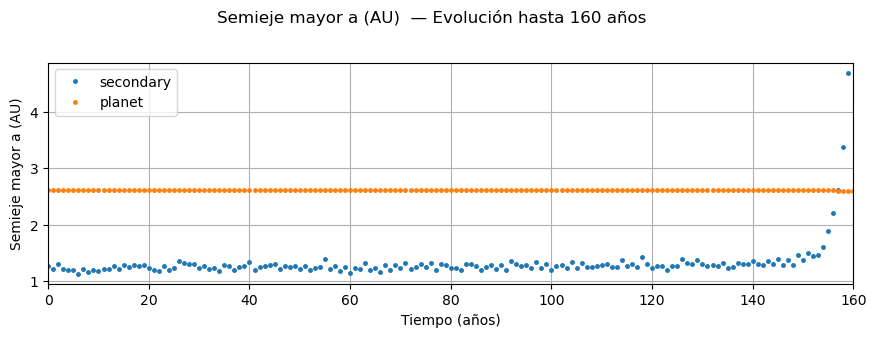

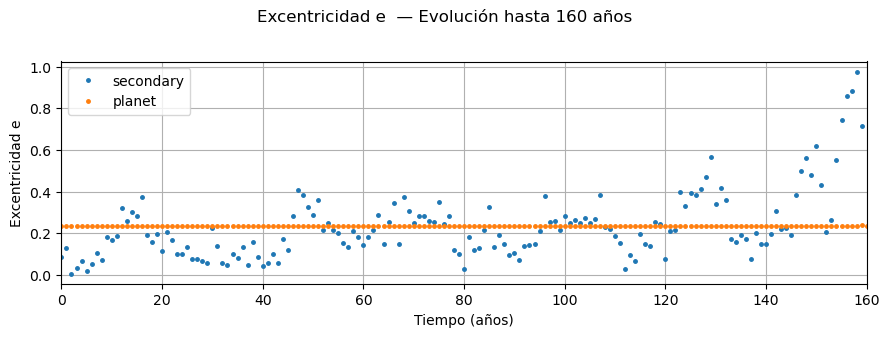

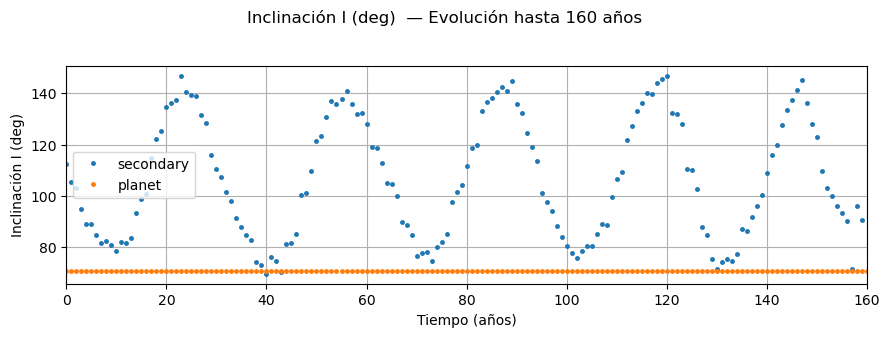

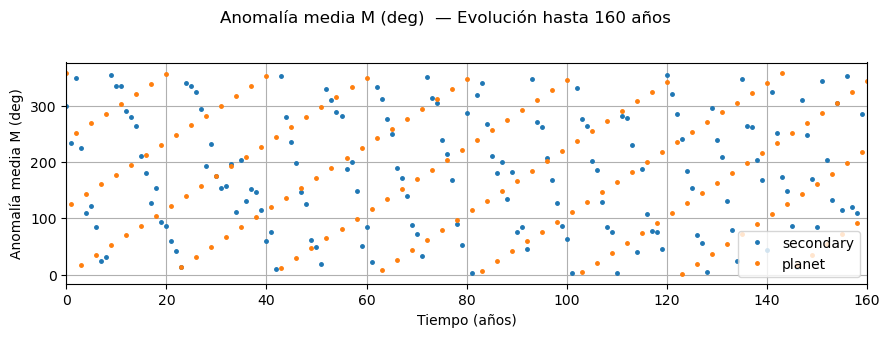

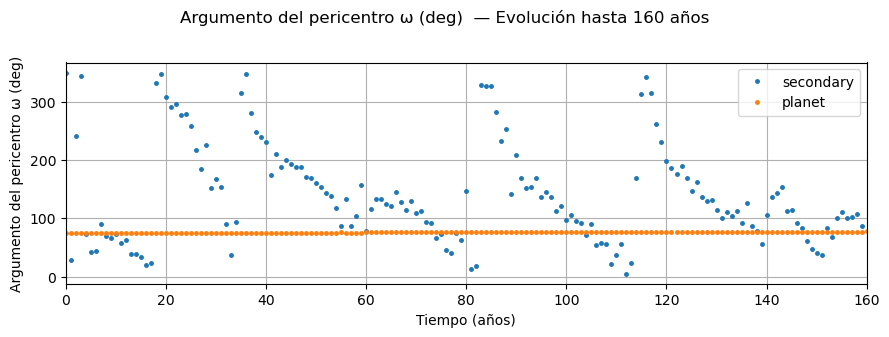

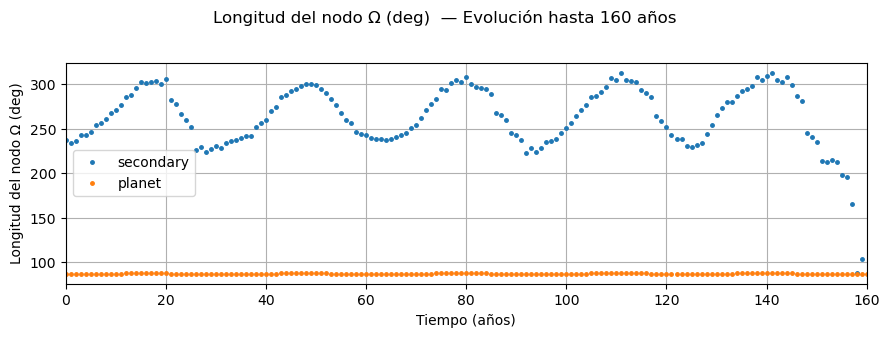

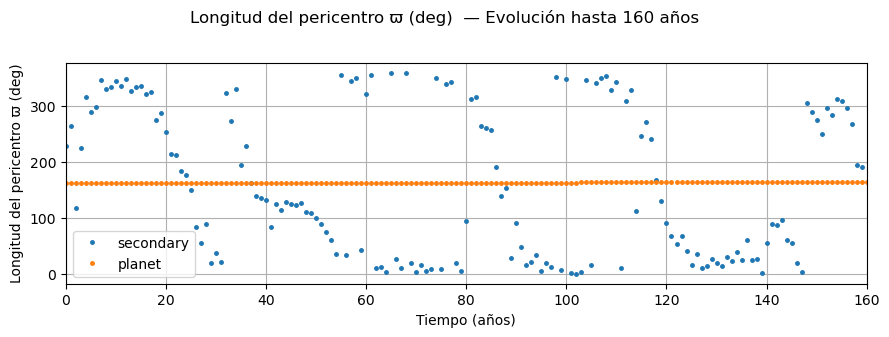

In [4]:
import os
import glob
import numpy as np
import pandas as pd

# Cambie estas variables según sus archivos y los identificadores de cuerpo en su salida NCORP
file_candidate_list = ['ncorp13.dat', 'planets.dat', 'planet1.dat', 'planet2.dat', 'planets.dat']
body_ids = {'secondary': 2, 'planet': 3}   # valores por defecto; ajustar a los IDs usados en su salida
max_year = 160  # máximo tiempo a graficar en años

import matplotlib.pyplot as plt

def find_existing_file(candidates):
    for f in candidates:
        if os.path.exists(f):
            return f
    # intentar patrones comunes
    for pattern in ['planet*.dat', 'particles.dat', '*.dat']:
        matches = sorted(glob.glob(pattern))
        if matches:
            return matches[0]
    raise FileNotFoundError("No se encontró archivo de datos. Ajuste file_candidate_list.")

def load_elements(path, body_id=None, max_t=max_year):
    df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None, engine='python')
    ncol = df.shape[1]
    # Detección de formato: con o sin columna de id
    if ncol >= 8:
        # formato con columna i: t, i, a, e, inc, M, w, O, ...
        cols = {'t':0, 'i':1, 'a':2, 'e':3, 'inc':4, 'M':5, 'w':6, 'O':7}
        if body_id is not None:
            df = df[df[cols['i']] == body_id]
    elif ncol >= 7:
        # formato sin columna i (archivos individuales por cuerpo): t, a, e, inc, M, w, O, ...
        cols = {'t':0, 'a':1, 'e':2, 'inc':3, 'M':4, 'w':5, 'O':6}
    else:
        raise ValueError(f"Formato inesperado: {ncol} columnas en {path}")
    # Selección hasta max_t
    df = df[df[cols['t']] <= max_t].copy()
    # Crear dataframe con nombres
    out = pd.DataFrame()
    out['t'] = df.iloc[:, cols['t']].astype(float)
    out['a'] = df.iloc[:, cols['a']].astype(float)
    out['e'] = df.iloc[:, cols['e']].astype(float)
    out['inc'] = df.iloc[:, cols['inc']].astype(float)
    out['M'] = df.iloc[:, cols['M']].astype(float)
    out['w'] = df.iloc[:, cols['w']].astype(float)
    out['O'] = df.iloc[:, cols['O']].astype(float)
    # Longitud del pericentro ϖ = Ω + ω, normalizada a [0,360)
    out['varpi'] = (out['w'] + out['O']) % 360.0
    return out.sort_values('t')

# Intentar cargar datos para cada cuerpo. Si no existe archivo específico, usar same file y filtrar por id.
data_sources = {}
# primer intento: usar ncorp13.dat o planets.dat según existencia
base_file = find_existing_file(file_candidate_list)
for role, bid in body_ids.items():
    # si hay archivos individuales planetX.dat y role contiene "planet" tratar de localizar planet*.dat
    if role.lower().startswith('planet'):
        candidate = next(iter(sorted(glob.glob('planet*.dat'))), None)
        path = candidate if candidate and os.path.exists(candidate) else base_file
    else:
        # buscar planetN.dat para el planeta, o usar base_file
        candidate = next(iter(sorted(glob.glob(f'*{role}*.dat'))), None)
        path = candidate if candidate and os.path.exists(candidate) else base_file
    try:
        data_sources[role] = load_elements(path, body_id=bid, max_t=max_year)
    except Exception:
        # si falló filtrado por id (archivo individual sin columna i), intentar sin body_id
        try:
            data_sources[role] = load_elements(path, body_id=None, max_t=max_year)
        except Exception as e:
            print(f"No se pudieron cargar datos para {role} desde {path}: {e}")
            data_sources[role] = None

# Plots: a, e, inc, M, w, O, varpi
elements = [
    ('a', 'Semieje mayor a (AU)'),
    ('e', 'Excentricidad e'),
    ('inc', 'Inclinación I (deg)'),
    ('M', 'Anomalía media M (deg)'),
    ('w', 'Argumento del pericentro ω (deg)'),
    ('O', 'Longitud del nodo Ω (deg)'),
    ('varpi', 'Longitud del pericentro ϖ (deg)')
]

colors = {'secondary':'C0', 'planet':'C1'}
plt.rcParams.update({'figure.max_open_warning': 0})

# Crear una figura separada por cada elemento y usar puntos
for key, ylabel in elements:
    fig, ax = plt.subplots(figsize=(9, 3.5))
    plotted = False
    for role, df in data_sources.items():
        if df is None or df.empty:
            continue
        ax.plot(df['t'], df[key], marker='.', linestyle='None', markersize=5, label=role, color=colors.get(role, None))
        plotted = True
    if not plotted:
        ax.text(0.5, 0.5, 'No hay datos para este elemento', ha='center', va='center', transform=ax.transAxes)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, max_year)
    ax.grid(True)
    ax.legend(loc='best')
    ax.set_xlabel('Tiempo (años)')
    fig.suptitle(f'{ylabel}  — Evolución hasta {max_year} años', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

In [6]:
# Acá descargamos los gráficos generados en una carpeta llamada "secular_plots"

output_dir = 'secular_plots'
os.makedirs(output_dir, exist_ok=True)  
for key, ylabel in elements:
    fig, ax = plt.subplots(figsize=(9, 3.5))
    plotted = False
    for role, df in data_sources.items():
        if df is None or df.empty:
            continue
        ax.plot(df['t'], df[key], marker='.', linestyle='None', markersize=5, label=role, color=colors.get(role, None))
        plotted = True
    if not plotted:
        ax.text(0.5, 0.5, 'No hay datos para este elemento', ha='center', va='center', transform=ax.transAxes)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, max_year)
    ax.grid(True)
    ax.legend(loc='best')
    ax.set_xlabel('Tiempo (años)')
    fig.suptitle(f'{ylabel}  — Evolución hasta {max_year} años', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    # Guardar la figura en la carpeta secular_plots
    output_path = os.path.join(output_dir, f'{key}_secular_plot.png')
    fig.savefig(output_path)
    plt.close(fig)
    print(f'Gráfico guardado: {output_path}')
print("Todos los gráficos han sido guardados en la carpeta 'secular_plots'.")








Gráfico guardado: secular_plots/a_secular_plot.png
Gráfico guardado: secular_plots/e_secular_plot.png
Gráfico guardado: secular_plots/inc_secular_plot.png
Gráfico guardado: secular_plots/M_secular_plot.png
Gráfico guardado: secular_plots/w_secular_plot.png
Gráfico guardado: secular_plots/O_secular_plot.png
Gráfico guardado: secular_plots/varpi_secular_plot.png
Todos los gráficos han sido guardados en la carpeta 'secular_plots'.


secondary | a: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=0.0366092  P=160
   2: f=0.425  A=0.0110475  P=2.35294
   3: f=0.49375  A=0.010232  P=2.02532
   4: f=0.4375  A=0.0101131  P=2.28571
   5: f=0.475  A=0.00939649  P=2.10526
   6: f=0.43125  A=0.00909057  P=2.31884
   7: f=0.41875  A=0.0090374  P=2.38806
   8: f=0.4875  A=0.00872579  P=2.05128
   9: f=0.23125  A=0.00788955  P=4.32432
  10: f=0.25625  A=0.00762513  P=3.90244
  11: f=0.14375  A=0.00750891  P=6.95652
  12: f=0.44375  A=0.00643299  P=2.25352
  13: f=0.225  A=0.00631863  P=4.44444
  14: f=0.1375  A=0.00625775  P=7.27273
  15: f=0.2375  A=0.00617183  P=4.21053


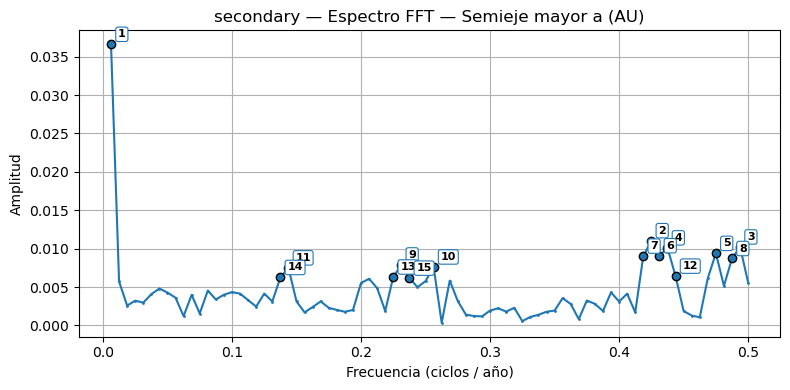

secondary | e: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0375  A=0.0358587  P=26.6667
   2: f=0.05  A=0.0190214  P=20
   3: f=0.01875  A=0.0187483  P=53.3333
   4: f=0.0875  A=0.0173523  P=11.4286
   5: f=0.05625  A=0.0166708  P=17.7778
   6: f=0.0125  A=0.0166635  P=80
   7: f=0.03125  A=0.016416  P=32
   8: f=0.1  A=0.014899  P=10
   9: f=0.00625  A=0.014345  P=160
  10: f=0.09375  A=0.0134171  P=10.6667
  11: f=0.08125  A=0.0133204  P=12.3077
  12: f=0.04375  A=0.0131964  P=22.8571
  13: f=0.025  A=0.012967  P=40
  14: f=0.2625  A=0.0110737  P=3.80952
  15: f=0.10625  A=0.0108742  P=9.41176


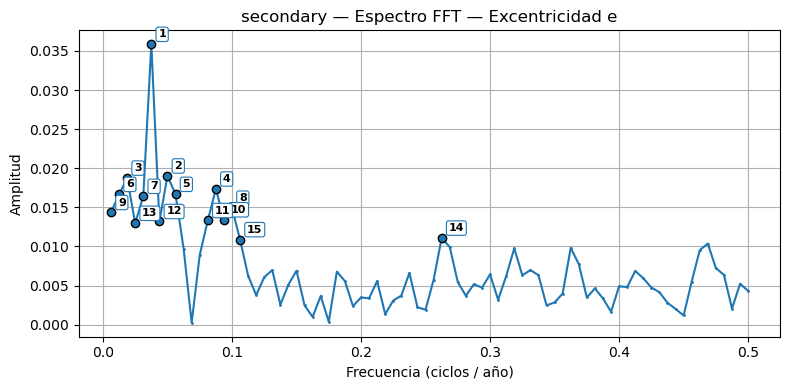

secondary | inc: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.03125  A=0.276833  P=32
   2: f=0.0375  A=0.176474  P=26.6667
   3: f=0.025  A=0.103992  P=40
   4: f=0.00625  A=0.0218298  P=160
   5: f=0.0625  A=0.0173974  P=16
   6: f=0.04375  A=0.0168693  P=22.8571
   7: f=0.0125  A=0.0161176  P=80
   8: f=0.05625  A=0.0151262  P=17.7778
   9: f=0.01875  A=0.0140434  P=53.3333
  10: f=0.33125  A=0.0118939  P=3.01887
  11: f=0.075  A=0.0109433  P=13.3333
  12: f=0.31875  A=0.0104805  P=3.13725
  13: f=0.3375  A=0.00905516  P=2.96296
  14: f=0.0875  A=0.00792716  P=11.4286
  15: f=0.38125  A=0.00758517  P=2.62295


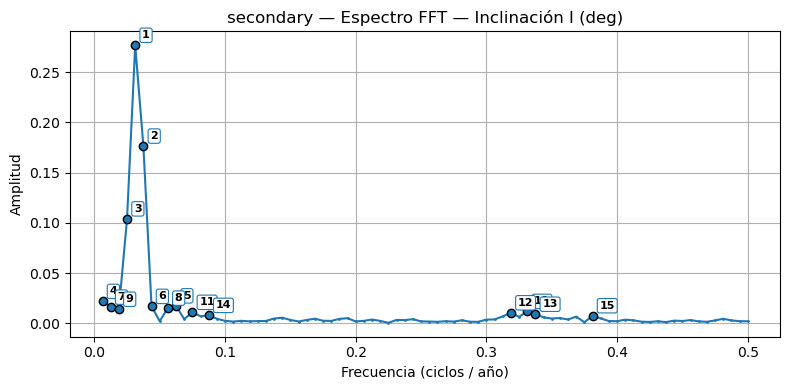

secondary | M: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=11.2699  P=160
   2: f=0.0125  A=3.08689  P=80
   3: f=0.0375  A=0.425509  P=26.6667
   4: f=0.01875  A=0.402042  P=53.3333
   5: f=0.03125  A=0.385294  P=32
   6: f=0.025  A=0.367542  P=40
   7: f=0.0625  A=0.240484  P=16
   8: f=0.05  A=0.172599  P=20
   9: f=0.06875  A=0.14154  P=14.5455
  10: f=0.04375  A=0.141273  P=22.8571
  11: f=0.075  A=0.128736  P=13.3333
  12: f=0.125  A=0.114081  P=8
  13: f=0.09375  A=0.105972  P=10.6667
  14: f=0.11875  A=0.105089  P=8.42105
  15: f=0.15  A=0.0951456  P=6.66667


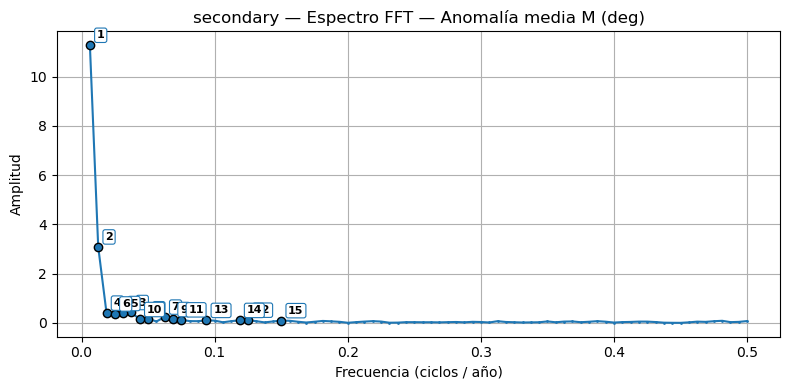

secondary | w: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=2.67237  P=160
   2: f=0.0125  A=0.851793  P=80
   3: f=0.01875  A=0.806866  P=53.3333
   4: f=0.025  A=0.472353  P=40
   5: f=0.05625  A=0.26611  P=17.7778
   6: f=0.04375  A=0.176982  P=22.8571
   7: f=0.03125  A=0.175243  P=32
   8: f=0.0625  A=0.161674  P=16
   9: f=0.05  A=0.145384  P=20
  10: f=0.08125  A=0.132763  P=12.3077
  11: f=0.0875  A=0.122378  P=11.4286
  12: f=0.10625  A=0.098855  P=9.41176
  13: f=0.1375  A=0.0977038  P=7.27273
  14: f=0.1125  A=0.0917887  P=8.88889
  15: f=0.48125  A=0.0834504  P=2.07792


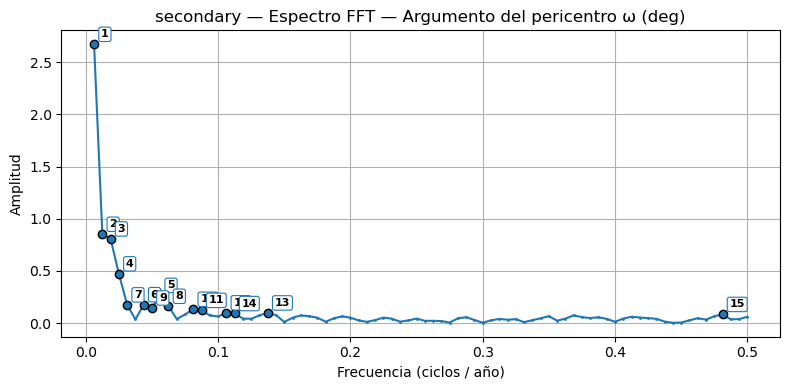

secondary | O: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.03125  A=0.311641  P=32
   2: f=0.0375  A=0.193279  P=26.6667
   3: f=0.025  A=0.128473  P=40
   4: f=0.00625  A=0.0411481  P=160
   5: f=0.0625  A=0.0328862  P=16
   6: f=0.04375  A=0.0256213  P=22.8571
   7: f=0.01875  A=0.0193376  P=53.3333
   8: f=0.05625  A=0.018402  P=17.7778
   9: f=0.0125  A=0.0163458  P=80
  10: f=0.075  A=0.0144585  P=13.3333
  11: f=0.38125  A=0.0114715  P=2.62295
  12: f=0.33125  A=0.0106689  P=3.01887
  13: f=0.0875  A=0.0105856  P=11.4286
  14: f=0.09375  A=0.00933297  P=10.6667
  15: f=0.3375  A=0.00860339  P=2.96296


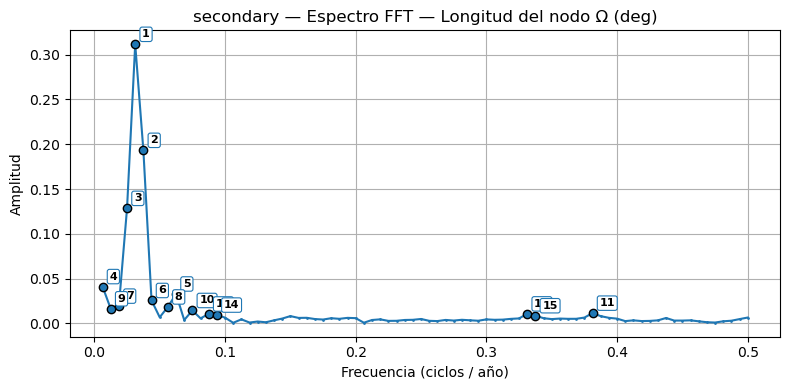

secondary | varpi: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=2.63815  P=160
   2: f=0.0125  A=0.867999  P=80
   3: f=0.01875  A=0.818804  P=53.3333
   4: f=0.025  A=0.580729  P=40
   5: f=0.03125  A=0.404271  P=32
   6: f=0.05625  A=0.283026  P=17.7778
   7: f=0.0625  A=0.193416  P=16
   8: f=0.0375  A=0.163179  P=26.6667
   9: f=0.04375  A=0.157914  P=22.8571
  10: f=0.05  A=0.152098  P=20
  11: f=0.08125  A=0.127529  P=12.3077
  12: f=0.0875  A=0.113167  P=11.4286
  13: f=0.1375  A=0.0989735  P=7.27273
  14: f=0.10625  A=0.0987176  P=9.41176
  15: f=0.1125  A=0.0899895  P=8.88889


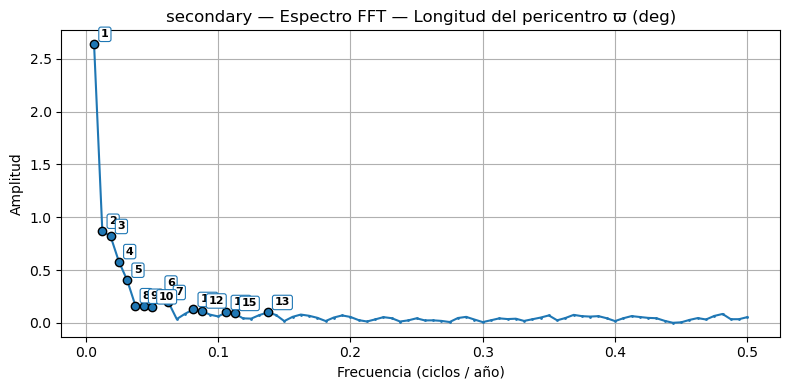

planet | a: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.000390661  P=161
   2: f=0.0248447  A=0.000144709  P=40.25
   3: f=0.0186335  A=0.000140781  P=53.6667
   4: f=0.124224  A=0.000120278  P=8.05
   5: f=0.0621118  A=0.000113141  P=16.1
   6: f=0.118012  A=0.000107761  P=8.47368
   7: f=0.0124224  A=0.000105468  P=80.5
   8: f=0.111801  A=0.000103109  P=8.94444
   9: f=0.0372671  A=9.72424e-05  P=26.8333
  10: f=0.440994  A=9.65963e-05  P=2.26761


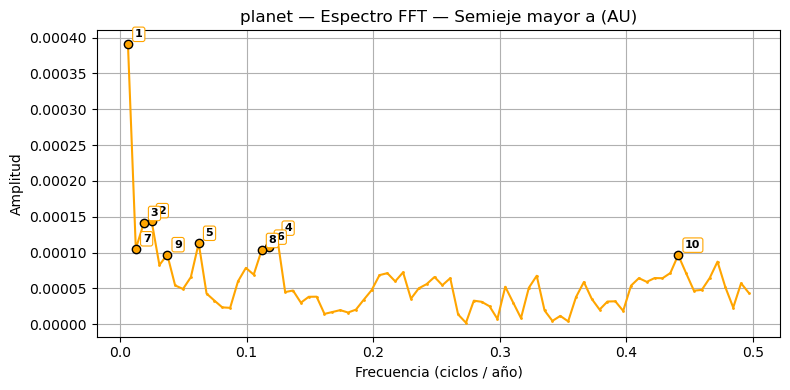

planet | e: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=8.33426e-05  P=161
   2: f=0.124224  A=6.37534e-05  P=8.05
   3: f=0.118012  A=4.65874e-05  P=8.47368
   4: f=0.0248447  A=3.7633e-05  P=40.25
   5: f=0.111801  A=3.72004e-05  P=8.94444
   6: f=0.10559  A=3.50951e-05  P=9.47059
   7: f=0.0931677  A=3.09489e-05  P=10.7333
   8: f=0.130435  A=2.99844e-05  P=7.66667
   9: f=0.347826  A=2.95969e-05  P=2.875
  10: f=0.0496894  A=2.79695e-05  P=20.125


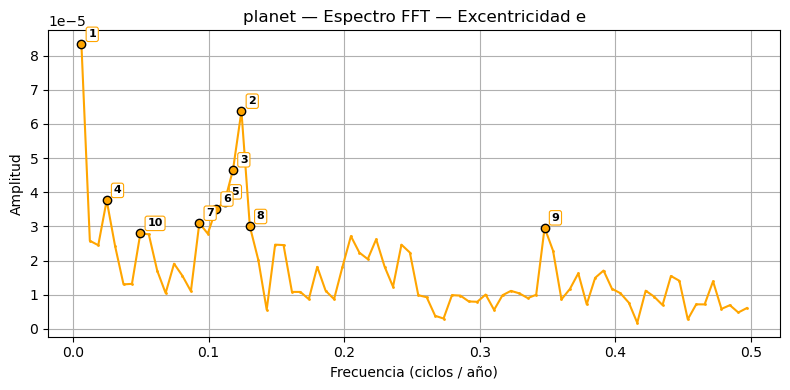

planet | inc: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0310559  A=0.000735514  P=32.2
   2: f=0.0372671  A=0.000494317  P=26.8333
   3: f=0.0248447  A=0.000257491  P=40.25
   4: f=0.0434783  A=5.25459e-05  P=23
   5: f=0.00621118  A=4.87469e-05  P=161
   6: f=0.0124224  A=4.72666e-05  P=80.5
   7: f=0.0186335  A=3.78411e-05  P=53.6667
   8: f=0.0745342  A=3.25489e-05  P=13.4167
   9: f=0.068323  A=3.17874e-05  P=14.6364
  10: f=0.335404  A=2.94994e-05  P=2.98148


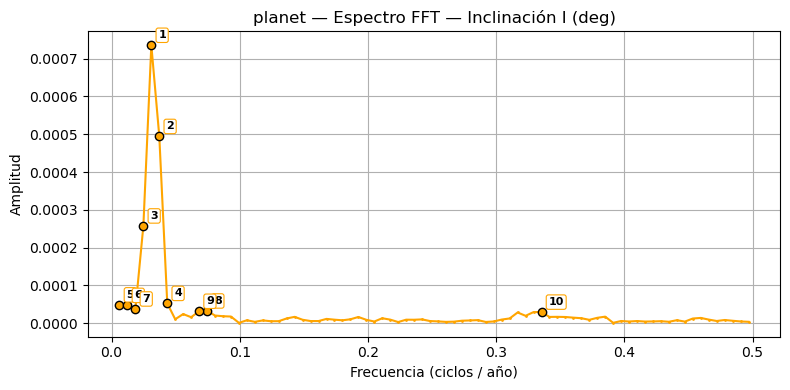

planet | M: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=41.7322  P=161
   2: f=0.0124224  A=9.69078  P=80.5
   3: f=0.0186335  A=2.40761  P=53.6667
   4: f=0.0248447  A=0.961247  P=40.25
   5: f=0.0310559  A=0.478761  P=32.2
   6: f=0.0372671  A=0.273102  P=26.8333
   7: f=0.0434783  A=0.170367  P=23
   8: f=0.0496894  A=0.113119  P=20.125
   9: f=0.0559006  A=0.0789461  P=17.8889
  10: f=0.0621118  A=0.0572707  P=16.1


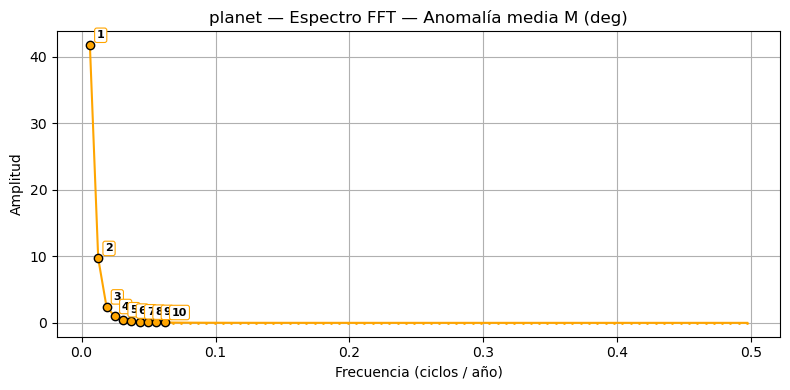

planet | w: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.00371331  P=161
   2: f=0.0124224  A=0.00101995  P=80.5
   3: f=0.124224  A=0.000267804  P=8.05
   4: f=0.0993789  A=0.000217979  P=10.0625
   5: f=0.223602  A=0.000206828  P=4.47222
   6: f=0.10559  A=0.000190286  P=9.47059
   7: f=0.0310559  A=0.00017857  P=32.2
   8: f=0.229814  A=0.000176933  P=4.35135
   9: f=0.0186335  A=0.00016907  P=53.6667
  10: f=0.118012  A=0.000163298  P=8.47368


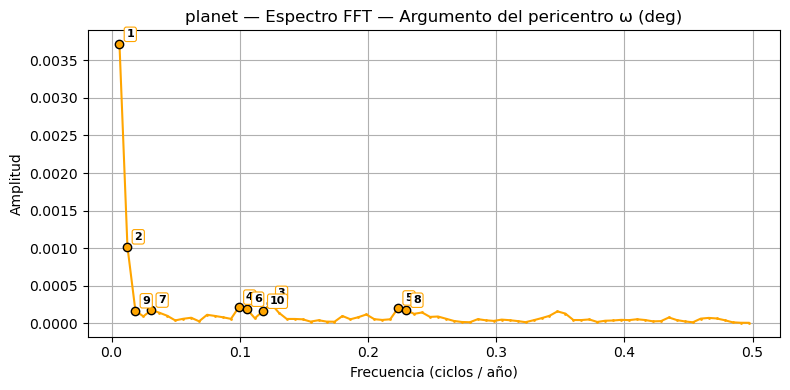

planet | O: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0310559  A=0.000782083  P=32.2
   2: f=0.0372671  A=0.000518043  P=26.8333
   3: f=0.0248447  A=0.000304925  P=40.25
   4: f=0.00621118  A=6.89937e-05  P=161
   5: f=0.0434783  A=6.87801e-05  P=23
   6: f=0.0186335  A=5.03272e-05  P=53.6667
   7: f=0.0124224  A=4.24879e-05  P=80.5
   8: f=0.068323  A=3.98366e-05  P=14.6364
   9: f=0.0745342  A=3.689e-05  P=13.4167
  10: f=0.0559006  A=3.55753e-05  P=17.8889


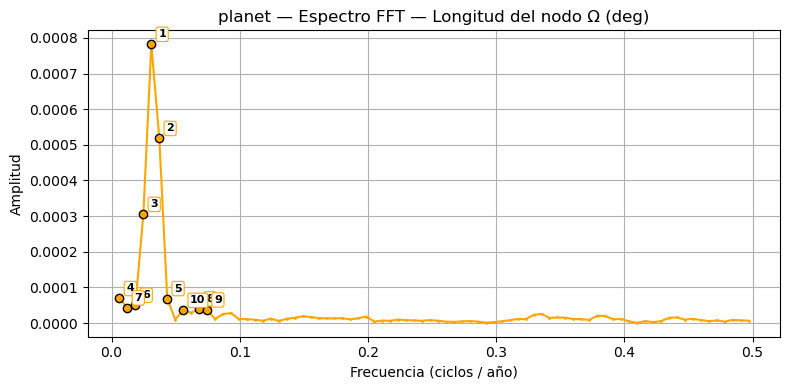

planet | varpi: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.00377659  P=161
   2: f=0.0124224  A=0.000978807  P=80.5
   3: f=0.0310559  A=0.00061947  P=32.2
   4: f=0.0372671  A=0.000517317  P=26.8333
   5: f=0.124224  A=0.000265197  P=8.05
   6: f=0.0248447  A=0.000216707  P=40.25
   7: f=0.0186335  A=0.000214204  P=53.6667
   8: f=0.0993789  A=0.000209398  P=10.0625
   9: f=0.223602  A=0.000197407  P=4.47222
  10: f=0.10559  A=0.000196837  P=9.47059


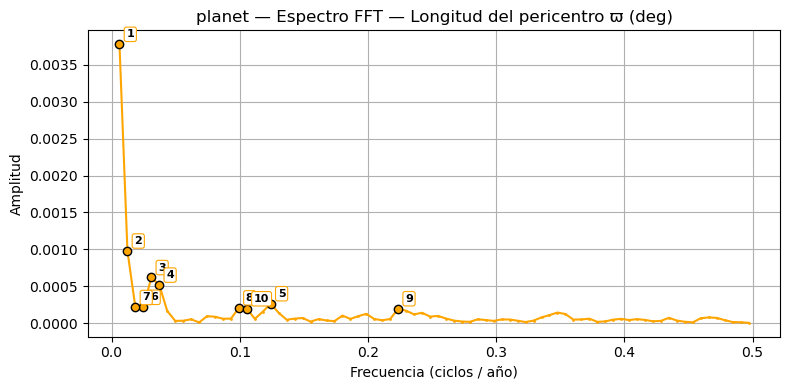

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def compute_and_plot_fft(data_sources, elements, max_year=None, markersize=2, top_n=10, marker_peak_size=6):
    angle_keys = {'M','w','O','varpi','inc'}
    for role, df in data_sources.items():
        if df is None or df.empty:
            print(f"No hay datos para {role}")
            continue

        role_l = role.lower()
        # color por rol: planet -> naranja
        role_color = 'orange' if 'planet' in role_l else 'C0'
        # top por rol: secundaria -> 15, planeta -> 10, fallback a top_n
        if 'secondary' in role_l:
            role_top_n = 15
        elif 'planet' in role_l:
            role_top_n = 10
        else:
            role_top_n = top_n

        for key, ylabel in elements:
            t = df['t'].values
            if max_year is not None:
                mask = t <= max_year
                t = t[mask]
                y = df[key].values[mask]
            else:
                y = df[key].values

            if len(t) < 4:
                print(f"{role} — {key}: datos insuficientes")
                continue

            if key in angle_keys:
                y_rad = np.deg2rad(y.astype(float))
                y_proc = np.unwrap(y_rad)
            else:
                y_proc = y.astype(float)

            dt = np.median(np.diff(t))
            if dt <= 0:
                print(f"{role} — {key}: dt no válido")
                continue
            t_uniform = np.arange(t[0], t[-1] + 0.5*dt, dt)
            y_uniform = np.interp(t_uniform, t, y_proc)

            y_uniform = y_uniform - np.mean(y_uniform)
            window = np.hanning(len(y_uniform))
            y_win = y_uniform * window

            N = len(y_win)
            yf = np.fft.rfft(y_win)
            freq = np.fft.rfftfreq(N, d=dt)
            amp = np.abs(yf) * 2.0 / N

            valid = freq > 0
            freq_v = freq[valid]
            amp_v = amp[valid]

            fig, ax = plt.subplots(figsize=(8,4))
            ax.plot(freq_v, amp_v, marker='.', linestyle='-', markersize=markersize, color=role_color, label=role)
            ax.set_xlabel('Frecuencia (ciclos / año)')
            ax.set_ylabel('Amplitud')
            ax.set_title(f'{role} — Espectro FFT — {ylabel}')
            ax.grid(True)

            if len(amp_v) > 0:
                idx = np.argsort(amp_v)[-role_top_n:][::-1]
                peaks = [(freq_v[i], amp_v[i]) for i in idx]
                print(f'{role} | {key}: top {role_top_n} frecuencias (ciclos/año), amplitud, periodo (años):')
                for rank, (fval, aval) in enumerate(peaks, start=1):
                    per = (1.0/fval if fval>0 else np.inf)
                    print(f'  {rank:2d}: f={fval:.6g}  A={aval:.6g}  P={per:.6g}')
                    # marcar pico con punto y anotar con el número de orden (rank)
                    ax.plot(fval, aval, marker='o', color=role_color, markersize=marker_peak_size, markeredgecolor='k')
                    ax.annotate(str(rank), xy=(fval, aval), xytext=(5,5), textcoords='offset points',
                                fontsize=8, fontweight='bold', color='k',
                                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=role_color, lw=0.8))

            plt.tight_layout()
            plt.show()

# Ejecutar análisis FFT por cuerpo y por elemento (top por rol: secundaria=15, planeta=10)
compute_and_plot_fft(data_sources, elements, max_year=max_year, markersize=2, top_n=10, marker_peak_size=6)


secondary | a: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=0.0366092  P=160
   2: f=0.425  A=0.0110475  P=2.35294
   3: f=0.49375  A=0.010232  P=2.02532
   4: f=0.4375  A=0.0101131  P=2.28571
   5: f=0.475  A=0.00939649  P=2.10526
   6: f=0.43125  A=0.00909057  P=2.31884
   7: f=0.41875  A=0.0090374  P=2.38806
   8: f=0.4875  A=0.00872579  P=2.05128
   9: f=0.23125  A=0.00788955  P=4.32432
  10: f=0.25625  A=0.00762513  P=3.90244
  11: f=0.14375  A=0.00750891  P=6.95652
  12: f=0.44375  A=0.00643299  P=2.25352
  13: f=0.225  A=0.00631863  P=4.44444
  14: f=0.1375  A=0.00625775  P=7.27273
  15: f=0.2375  A=0.00617183  P=4.21053


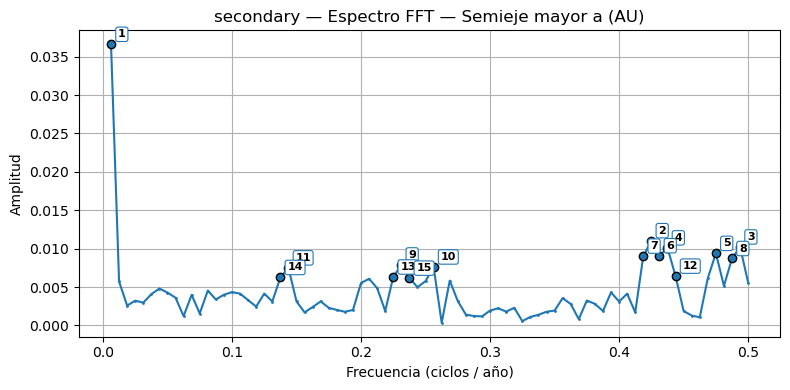

secondary | e: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0375  A=0.0358587  P=26.6667
   2: f=0.05  A=0.0190214  P=20
   3: f=0.01875  A=0.0187483  P=53.3333
   4: f=0.0875  A=0.0173523  P=11.4286
   5: f=0.05625  A=0.0166708  P=17.7778
   6: f=0.0125  A=0.0166635  P=80
   7: f=0.03125  A=0.016416  P=32
   8: f=0.1  A=0.014899  P=10
   9: f=0.00625  A=0.014345  P=160
  10: f=0.09375  A=0.0134171  P=10.6667
  11: f=0.08125  A=0.0133204  P=12.3077
  12: f=0.04375  A=0.0131964  P=22.8571
  13: f=0.025  A=0.012967  P=40
  14: f=0.2625  A=0.0110737  P=3.80952
  15: f=0.10625  A=0.0108742  P=9.41176


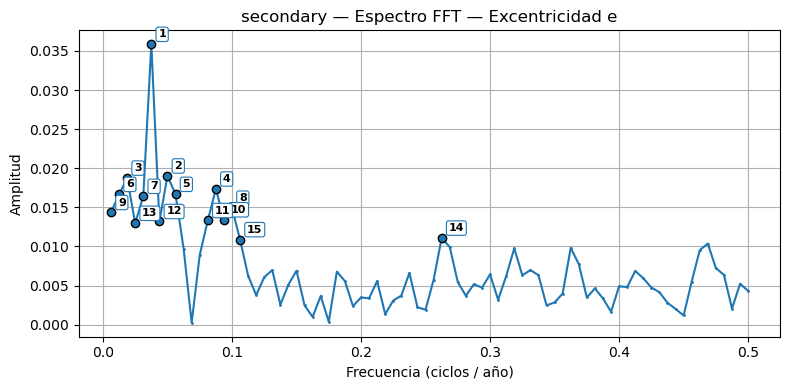

secondary | inc: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.03125  A=0.276833  P=32
   2: f=0.0375  A=0.176474  P=26.6667
   3: f=0.025  A=0.103992  P=40
   4: f=0.00625  A=0.0218298  P=160
   5: f=0.0625  A=0.0173974  P=16
   6: f=0.04375  A=0.0168693  P=22.8571
   7: f=0.0125  A=0.0161176  P=80
   8: f=0.05625  A=0.0151262  P=17.7778
   9: f=0.01875  A=0.0140434  P=53.3333
  10: f=0.33125  A=0.0118939  P=3.01887
  11: f=0.075  A=0.0109433  P=13.3333
  12: f=0.31875  A=0.0104805  P=3.13725
  13: f=0.3375  A=0.00905516  P=2.96296
  14: f=0.0875  A=0.00792716  P=11.4286
  15: f=0.38125  A=0.00758517  P=2.62295


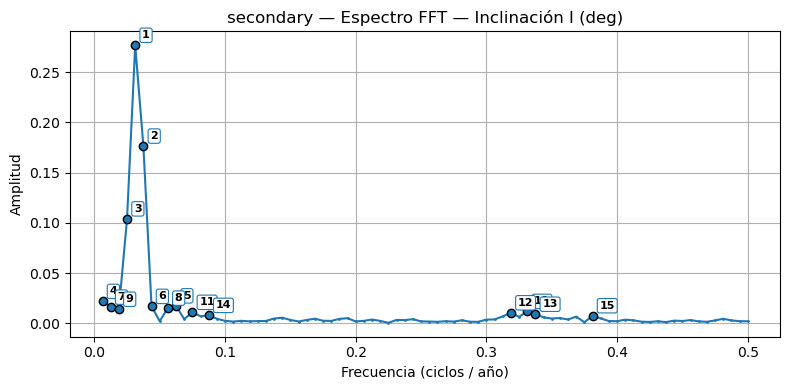

secondary | M: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=11.2699  P=160
   2: f=0.0125  A=3.08689  P=80
   3: f=0.0375  A=0.425509  P=26.6667
   4: f=0.01875  A=0.402042  P=53.3333
   5: f=0.03125  A=0.385294  P=32
   6: f=0.025  A=0.367542  P=40
   7: f=0.0625  A=0.240484  P=16
   8: f=0.05  A=0.172599  P=20
   9: f=0.06875  A=0.14154  P=14.5455
  10: f=0.04375  A=0.141273  P=22.8571
  11: f=0.075  A=0.128736  P=13.3333
  12: f=0.125  A=0.114081  P=8
  13: f=0.09375  A=0.105972  P=10.6667
  14: f=0.11875  A=0.105089  P=8.42105
  15: f=0.15  A=0.0951456  P=6.66667


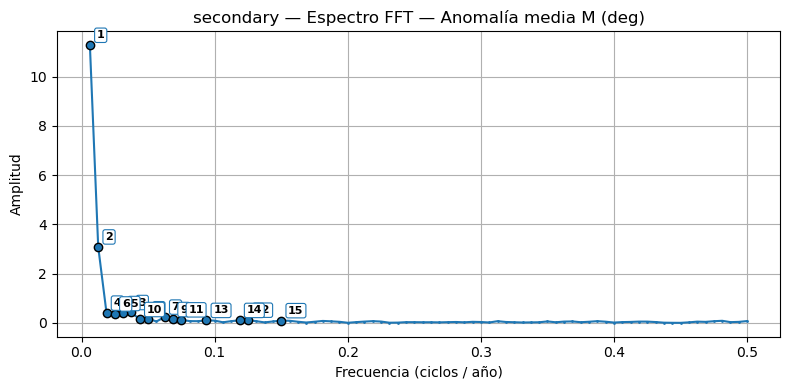

secondary | w: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=2.67237  P=160
   2: f=0.0125  A=0.851793  P=80
   3: f=0.01875  A=0.806866  P=53.3333
   4: f=0.025  A=0.472353  P=40
   5: f=0.05625  A=0.26611  P=17.7778
   6: f=0.04375  A=0.176982  P=22.8571
   7: f=0.03125  A=0.175243  P=32
   8: f=0.0625  A=0.161674  P=16
   9: f=0.05  A=0.145384  P=20
  10: f=0.08125  A=0.132763  P=12.3077
  11: f=0.0875  A=0.122378  P=11.4286
  12: f=0.10625  A=0.098855  P=9.41176
  13: f=0.1375  A=0.0977038  P=7.27273
  14: f=0.1125  A=0.0917887  P=8.88889
  15: f=0.48125  A=0.0834504  P=2.07792


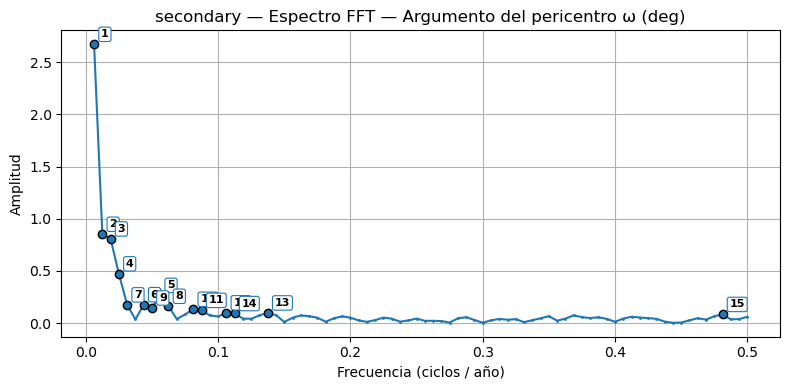

secondary | O: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.03125  A=0.311641  P=32
   2: f=0.0375  A=0.193279  P=26.6667
   3: f=0.025  A=0.128473  P=40
   4: f=0.00625  A=0.0411481  P=160
   5: f=0.0625  A=0.0328862  P=16
   6: f=0.04375  A=0.0256213  P=22.8571
   7: f=0.01875  A=0.0193376  P=53.3333
   8: f=0.05625  A=0.018402  P=17.7778
   9: f=0.0125  A=0.0163458  P=80
  10: f=0.075  A=0.0144585  P=13.3333
  11: f=0.38125  A=0.0114715  P=2.62295
  12: f=0.33125  A=0.0106689  P=3.01887
  13: f=0.0875  A=0.0105856  P=11.4286
  14: f=0.09375  A=0.00933297  P=10.6667
  15: f=0.3375  A=0.00860339  P=2.96296


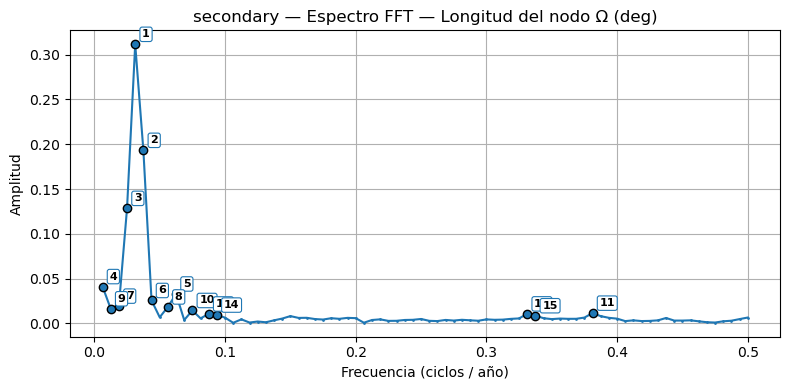

secondary | varpi: top 15 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00625  A=2.63815  P=160
   2: f=0.0125  A=0.867999  P=80
   3: f=0.01875  A=0.818804  P=53.3333
   4: f=0.025  A=0.580729  P=40
   5: f=0.03125  A=0.404271  P=32
   6: f=0.05625  A=0.283026  P=17.7778
   7: f=0.0625  A=0.193416  P=16
   8: f=0.0375  A=0.163179  P=26.6667
   9: f=0.04375  A=0.157914  P=22.8571
  10: f=0.05  A=0.152098  P=20
  11: f=0.08125  A=0.127529  P=12.3077
  12: f=0.0875  A=0.113167  P=11.4286
  13: f=0.1375  A=0.0989735  P=7.27273
  14: f=0.10625  A=0.0987176  P=9.41176
  15: f=0.1125  A=0.0899895  P=8.88889


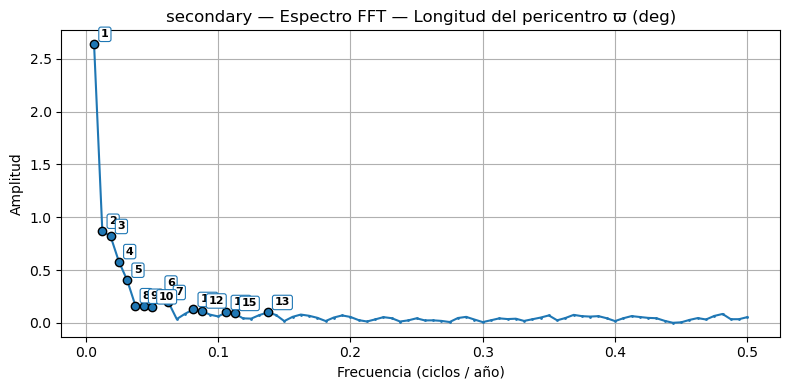

planet | a: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.000390661  P=161
   2: f=0.0248447  A=0.000144709  P=40.25
   3: f=0.0186335  A=0.000140781  P=53.6667
   4: f=0.124224  A=0.000120278  P=8.05
   5: f=0.0621118  A=0.000113141  P=16.1
   6: f=0.118012  A=0.000107761  P=8.47368
   7: f=0.0124224  A=0.000105468  P=80.5
   8: f=0.111801  A=0.000103109  P=8.94444
   9: f=0.0372671  A=9.72424e-05  P=26.8333
  10: f=0.440994  A=9.65963e-05  P=2.26761


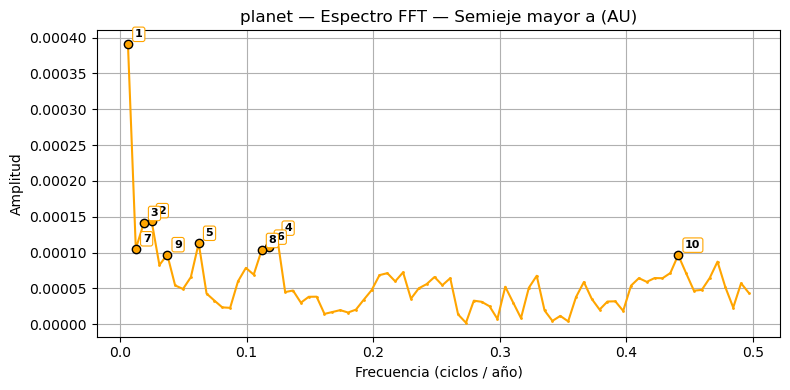

planet | e: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=8.33426e-05  P=161
   2: f=0.124224  A=6.37534e-05  P=8.05
   3: f=0.118012  A=4.65874e-05  P=8.47368
   4: f=0.0248447  A=3.7633e-05  P=40.25
   5: f=0.111801  A=3.72004e-05  P=8.94444
   6: f=0.10559  A=3.50951e-05  P=9.47059
   7: f=0.0931677  A=3.09489e-05  P=10.7333
   8: f=0.130435  A=2.99844e-05  P=7.66667
   9: f=0.347826  A=2.95969e-05  P=2.875
  10: f=0.0496894  A=2.79695e-05  P=20.125


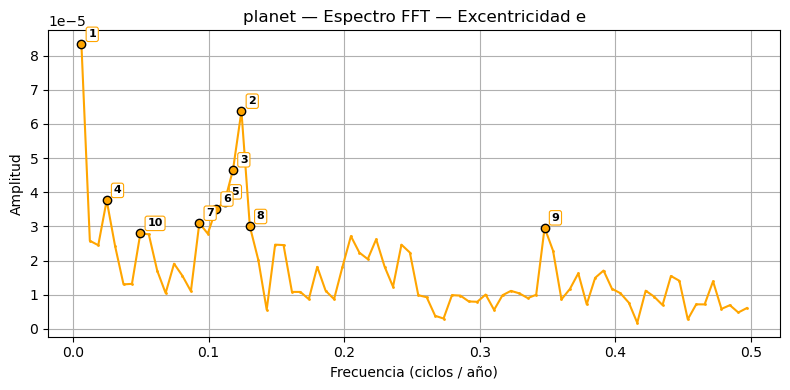

planet | inc: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0310559  A=0.000735514  P=32.2
   2: f=0.0372671  A=0.000494317  P=26.8333
   3: f=0.0248447  A=0.000257491  P=40.25
   4: f=0.0434783  A=5.25459e-05  P=23
   5: f=0.00621118  A=4.87469e-05  P=161
   6: f=0.0124224  A=4.72666e-05  P=80.5
   7: f=0.0186335  A=3.78411e-05  P=53.6667
   8: f=0.0745342  A=3.25489e-05  P=13.4167
   9: f=0.068323  A=3.17874e-05  P=14.6364
  10: f=0.335404  A=2.94994e-05  P=2.98148


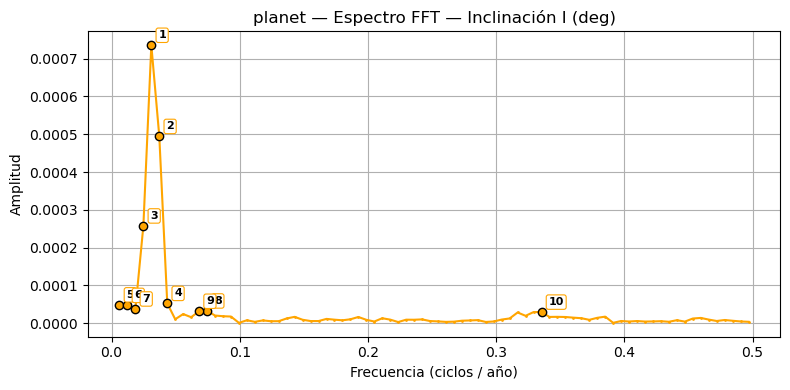

planet | M: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=41.7322  P=161
   2: f=0.0124224  A=9.69078  P=80.5
   3: f=0.0186335  A=2.40761  P=53.6667
   4: f=0.0248447  A=0.961247  P=40.25
   5: f=0.0310559  A=0.478761  P=32.2
   6: f=0.0372671  A=0.273102  P=26.8333
   7: f=0.0434783  A=0.170367  P=23
   8: f=0.0496894  A=0.113119  P=20.125
   9: f=0.0559006  A=0.0789461  P=17.8889
  10: f=0.0621118  A=0.0572707  P=16.1


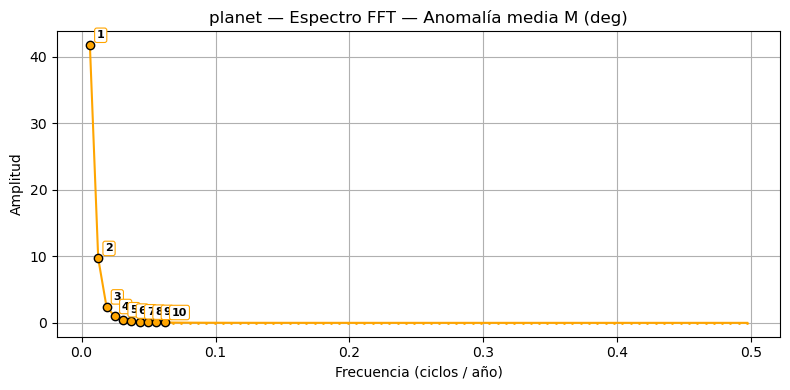

planet | w: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.00371331  P=161
   2: f=0.0124224  A=0.00101995  P=80.5
   3: f=0.124224  A=0.000267804  P=8.05
   4: f=0.0993789  A=0.000217979  P=10.0625
   5: f=0.223602  A=0.000206828  P=4.47222
   6: f=0.10559  A=0.000190286  P=9.47059
   7: f=0.0310559  A=0.00017857  P=32.2
   8: f=0.229814  A=0.000176933  P=4.35135
   9: f=0.0186335  A=0.00016907  P=53.6667
  10: f=0.118012  A=0.000163298  P=8.47368


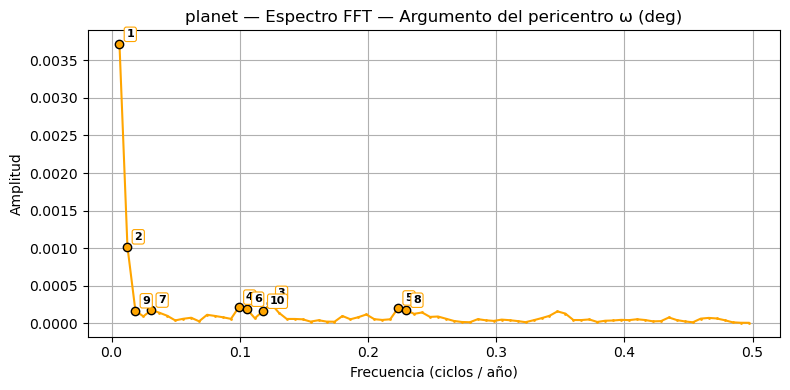

planet | O: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.0310559  A=0.000782083  P=32.2
   2: f=0.0372671  A=0.000518043  P=26.8333
   3: f=0.0248447  A=0.000304925  P=40.25
   4: f=0.00621118  A=6.89937e-05  P=161
   5: f=0.0434783  A=6.87801e-05  P=23
   6: f=0.0186335  A=5.03272e-05  P=53.6667
   7: f=0.0124224  A=4.24879e-05  P=80.5
   8: f=0.068323  A=3.98366e-05  P=14.6364
   9: f=0.0745342  A=3.689e-05  P=13.4167
  10: f=0.0559006  A=3.55753e-05  P=17.8889


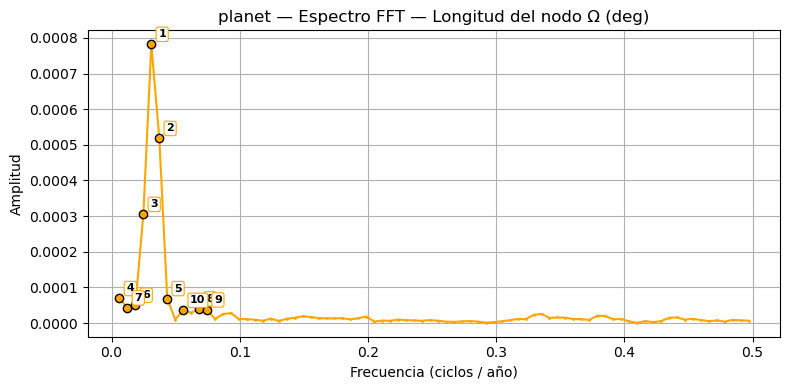

planet | varpi: top 10 frecuencias (ciclos/año), amplitud, periodo (años):
   1: f=0.00621118  A=0.00377659  P=161
   2: f=0.0124224  A=0.000978807  P=80.5
   3: f=0.0310559  A=0.00061947  P=32.2
   4: f=0.0372671  A=0.000517317  P=26.8333
   5: f=0.124224  A=0.000265197  P=8.05
   6: f=0.0248447  A=0.000216707  P=40.25
   7: f=0.0186335  A=0.000214204  P=53.6667
   8: f=0.0993789  A=0.000209398  P=10.0625
   9: f=0.223602  A=0.000197407  P=4.47222
  10: f=0.10559  A=0.000196837  P=9.47059


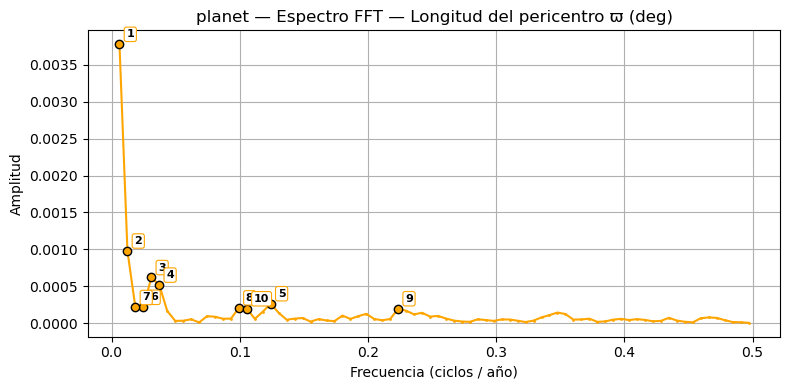

In [14]:

import numpy as np
import matplotlib.pyplot as plt

def compute_and_plot_fft(data_sources, elements, max_year=None, markersize=2, top_n=10, marker_peak_size=6):
    angle_keys = {'M','w','O','varpi','inc'}
    for role, df in data_sources.items():
        if df is None or df.empty:
            print(f"No hay datos para {role}")
            continue

        role_l = role.lower()
        # color por rol: planet -> naranja
        role_color = 'orange' if 'planet' in role_l else 'C0'
        # top por rol: secundaria -> 15, planeta -> 10, fallback a top_n
        if 'secondary' in role_l:
            role_top_n = 15
        elif 'planet' in role_l:
            role_top_n = 10
        else:
            role_top_n = top_n

        for key, ylabel in elements:
            t = df['t'].values
            if max_year is not None:
                mask = t <= max_year
                t = t[mask]
                y = df[key].values[mask]
            else:
                y = df[key].values

            if len(t) < 4:
                print(f"{role} — {key}: datos insuficientes")
                continue

            if key in angle_keys:
                y_rad = np.deg2rad(y.astype(float))
                y_proc = np.unwrap(y_rad)
            else:
                y_proc = y.astype(float)

            dt = np.median(np.diff(t))
            if dt <= 0:
                print(f"{role} — {key}: dt no válido")
                continue
            t_uniform = np.arange(t[0], t[-1] + 0.5*dt, dt)
            y_uniform = np.interp(t_uniform, t, y_proc)

            y_uniform = y_uniform - np.mean(y_uniform)
            window = np.hanning(len(y_uniform))
            y_win = y_uniform * window

            N = len(y_win)
            yf = np.fft.rfft(y_win)
            freq = np.fft.rfftfreq(N, d=dt)
            amp = np.abs(yf) * 2.0 / N

            valid = freq > 0
            freq_v = freq[valid]
            amp_v = amp[valid]

            fig, ax = plt.subplots(figsize=(8,4))
            ax.plot(freq_v, amp_v, marker='.', linestyle='-', markersize=markersize, color=role_color, label=role)
            ax.set_xlabel('Frecuencia (ciclos / año)')
            ax.set_ylabel('Amplitud')
            ax.set_title(f'{role} — Espectro FFT — {ylabel}')
            ax.grid(True)

            if len(amp_v) > 0:
                idx = np.argsort(amp_v)[-role_top_n:][::-1]
                peaks = [(freq_v[i], amp_v[i]) for i in idx]
                print(f'{role} | {key}: top {role_top_n} frecuencias (ciclos/año), amplitud, periodo (años):')
                for rank, (fval, aval) in enumerate(peaks, start=1):
                    per = (1.0/fval if fval>0 else np.inf)
                    print(f'  {rank:2d}: f={fval:.6g}  A={aval:.6g}  P={per:.6g}')
                    # marcar pico con punto y anotar con el número de orden (rank)
                    ax.plot(fval, aval, marker='o', color=role_color, markersize=marker_peak_size, markeredgecolor='k')
                    ax.annotate(str(rank), xy=(fval, aval), xytext=(5,5), textcoords='offset points',
                                fontsize=8, fontweight='bold', color='k',
                                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=role_color, lw=0.8))

            plt.tight_layout()
            plt.show()

# Ejecutar análisis FFT por cuerpo y por elemento (top por rol: secundaria=15, planeta=10)
compute_and_plot_fft(data_sources, elements, max_year=max_year, markersize=2, top_n=10, marker_peak_size=6)

In [22]:
# Acá guardo los gráficos generados en una carpeta llamada "secular_fft_plots"
import os
import pandas as pd

output_dir_fft = 'secular_fft_plots'
os.makedirs(output_dir_fft, exist_ok=True)

# parámetros por defecto usados en esta celda (evitan NameError)
top_n = 10
markersize = 2
marker_peak_size = 6

# definir claves de ángulo (se usan más abajo)
angle_keys = {'M', 'w', 'O', 'varpi', 'inc'}

for role, df in data_sources.items():
    if df is None or df.empty:
        print(f"No hay datos para {role}")
        continue

    role_l = role.lower()
    # color por rol: planet -> naranja
    role_color = 'orange' if 'planet' in role_l else 'C0'
    # top por rol: secundaria -> 15, planeta -> 10, fallback a top_n
    if 'secondary' in role_l:
        role_top_n = 15
    elif 'planet' in role_l:
        role_top_n = 10
    else:
        role_top_n = top_n

    for key, ylabel in elements:
        t = df['t'].values
        if max_year is not None:
            mask = t <= max_year
            t = t[mask]
            y = df[key].values[mask]
        else:
            y = df[key].values

        if len(t) < 4:
            print(f"{role} — {key}: datos insuficientes")
            continue

        if key in angle_keys:
            y_rad = np.deg2rad(y.astype(float))
            y_proc = np.unwrap(y_rad)
        else:
            y_proc = y.astype(float)

        dt = np.median(np.diff(t))
        if dt <= 0:
            print(f"{role} — {key}: dt no válido")
            continue
        t_uniform = np.arange(t[0], t[-1] + 0.5*dt, dt)
        y_uniform = np.interp(t_uniform, t, y_proc)

        y_uniform = y_uniform - np.mean(y_uniform)
        window = np.hanning(len(y_uniform))
        y_win = y_uniform * window

        N = len(y_win)
        yf = np.fft.rfft(y_win)
        freq = np.fft.rfftfreq(N, d=dt)
        amp = np.abs(yf) * 2.0 / N

        valid = freq > 0
        freq_v = freq[valid]
        amp_v = amp[valid]

        # figura principal con todos los picos destacados
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(freq_v, amp_v, marker='.', linestyle='-', markersize=markersize, color=role_color, label=role)
        ax.set_xlabel('Frecuencia (ciclos / año)')
        ax.set_ylabel('Amplitud')
        ax.set_title(f'{role} — Espectro FFT — {ylabel}')
        ax.grid(True)

        peaks_info = []
        if len(amp_v) > 0:
            idx = np.argsort(amp_v)[-role_top_n:][::-1]
            for rank, i in enumerate(idx, start=1):
                fval = float(freq_v[i])
                aval = float(amp_v[i])
                per = (1.0/fval if fval>0 else np.inf)
                peaks_info.append({'rank': rank, 'frequency_cpyear': fval, 'amplitude': aval, 'period_years': per})
                # marcar y anotar con número de orden
                ax.plot(fval, aval, marker='o', color=role_color, markersize=marker_peak_size, markeredgecolor='k')
                ax.annotate(str(rank), xy=(fval, aval), xytext=(5,5), textcoords='offset points',
                            fontsize=8, fontweight='bold', color='k',
                            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=role_color, lw=0.8))

        # leyenda y guardado
        ax.legend()
        plt.tight_layout()
        out_png = os.path.join(output_dir_fft, f'{role}_{key}_fft_top{role_top_n}.png')
        fig.savefig(out_png, dpi=200)
        plt.close(fig)
        print(f'Gráfico FFT (con top{role_top_n}) guardado: {out_png}')

        # guardar tabla con los picos topN
        if peaks_info:
            df_peaks = pd.DataFrame(peaks_info)
            out_csv = os.path.join(output_dir_fft, f'{role}_{key}_fft_top{role_top_n}.csv')
            df_peaks.to_csv(out_csv, index=False, float_format='%.6g')
            print(f'Tabla top{role_top_n} guardada: {out_csv}')

print("Todos los gráficos FFT (con tops) han sido guardados en la carpeta 'secular_fft_plots'.")

Gráfico FFT (con top15) guardado: secular_fft_plots/secondary_a_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secondary_a_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secondary_e_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secondary_e_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secondary_inc_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secondary_inc_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secondary_M_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secondary_M_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secondary_w_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secondary_w_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secondary_O_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secondary_O_fft_top15.csv
Gráfico FFT (con top15) guardado: secular_fft_plots/secondary_varpi_fft_top15.png
Tabla top15 guardada: secular_fft_plots/secondary_